<a href="https://colab.research.google.com/github/mfrdixon/MSRNN/blob/master/Alpha_RNNs_regime_switching_test_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Imports for stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score


# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Please see MFD: comments and "to do" comments

# Generate switching data set

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
#vols=generate_vol_sample(1000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

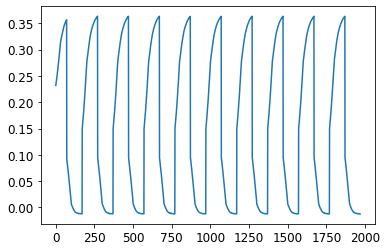

In [8]:
plt.plot(vols)

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

# prepare data for RNNs

In [0]:
use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.5
split = int(len(df)*train_weight)

df_train = df.iloc[:split]
df_test = df.iloc[split:]

In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [13]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(975, 10, 1) (975, 1, 1) (975, 10, 1) (975, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

time_size = y_train_reg.shape[1]


In [15]:
print(train_batch_size)

975


# Define Alpha RNN models

In [0]:
class alphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. It uses a hidden layer for smoothing
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Walpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Walpha')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ualpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ualpha')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.balpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='balpha')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha_t = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='alpha_t')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Update alpha_t
        self.alpha_t = tf.sigmoid(tf.matmul(x_t, self.Walpha) + tf.matmul(h_tm1, self.Ualpha) + self.balpha)
        tf.add_to_collection('alpha_t', self.alpha_t)
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - self.alpha_t, h_tm1) + tf.multiply(self.alpha_t, h_proposal)
        
        return h_t

In [17]:
tf.get_collection('alpha_t')

[]

In [0]:
class simpleAlphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. 
       It uses a scalar smoothing
    
    
    Arguments
    ---------
    
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
        
    Todo
    --------
    1) how to constrain alpha to be in [0,1]?
    2) when hidden size >1, how to couple with scalar alpha?
    3) Should alpha be a vector of size hidden_size (is this better)?
    4) Get value of fitted alpha (see Diagnostics (visualize fitted values)) below
    4) Adapt the training to use early stopping (instead of fixed number of epoches)
    5) Compare with GRU, LSTM, simpleRNN
        
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='alpha')
        
        #tf.placeholder(dtype=tf.float64, shape=(None, 1), name='alpha')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - self.alpha, h_tm1) + tf.multiply(self.alpha, h_proposal)
        
        return h_t

## Training

In [0]:
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reserved for the second term
input_dimensions = 1

# Arbitrary number for the size of the hidden state
hidden_size = 5 #<= MFD: vary this between 1,2,5,10,20


In [0]:
#l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

#regularized_loss = total_loss + regularization_penalty

In [0]:
def train(alpharnn, train_x, val_x, train_y, val_y, max_epochs=1500, batch_size=100, patience=5, min_delta=0.00001):
  
  
  # Create a placeholder for the expected output
  expected_output_batch_train = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size,1), name='expected_output_batch_train')
  expected_output_train = tf.placeholder(dtype=tf.float64, shape=(train_x.shape[0], time_size,1), name='expected_output_train')
  
  expected_output_val = tf.placeholder(dtype=tf.float64, shape=(val_x.shape[0], time_size,1), name='expected_output_val')

  #expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size), name='expected_output')

  # Just use quadratic loss
  train_batch_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_batch_train, 2)) / float(batch_size)
  train_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_train, 2)) / float(train_x.shape[0])
  validation_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(val_x.shape[0])

  #accuracy = tf.reduce_mean(tf.cast(validation_loss, tf.float64))

  # Use the Adam optimizer for training
  train_step = tf.train.AdamOptimizer().minimize(train_batch_loss)
    
  # Initialize the losses
  train_losses = []
  val_losses = []
      
  # Initialize all the variables
  init_variables = tf.global_variables_initializer()
      
  #myNumpyData = np.ones([10,20])
  session.run(init_variables) # , {gru.Y: np.ones([20,20])})
 
  # Perform all the iterations
  patience_cnt = 0
  for epoch in range(max_epochs): # Compute the losses

        total_batch = int(train_x.shape[0] / batch_size)
    
        for i in range(total_batch):
          #rand_index = np.random.choice(train_x.shape[0]-1, size=batch_size)
          batch_x = train_x[i*batch_size:((i+1)*batch_size)]
          batch_y = train_y[i*batch_size:((i+1)*batch_size)]
          session.run([train_step], feed_dict={alpharnn.input_layer: batch_x, expected_output_batch_train: batch_y})        
        train_loss_ = session.run(train_loss, feed_dict={alpharnn.input_layer: train_x, expected_output_train: train_y})
        validation_loss_ = session.run(validation_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y})

        # Log the losses
        train_losses += [train_loss_]
        val_losses += [validation_loss_]
          #mse = mean_squared_error(train_losses,validation_losses) <= this is wrong!
        

        if epoch % 50 == 0: 
            print('Epoch ', epoch, '/', max_epochs, ': ',
                      "\tTraining Loss: {:.5f}".format(train_loss_),
                      "\tValidation Loss: {:.5f}".format(validation_loss_),
                      #"\tMSE: {:.5f}".format(mse)"                      

                 )
        if epoch > 0 and (val_losses[epoch-1] - val_losses[epoch]) > min_delta:
            patience_cnt = 0
        else:
            patience_cnt += 1
            #print(patience_cnt)
        if patience_cnt > patience:
            print("Early stopping")
            break
  #print('\nMSE: ',mse)
  plt.plot(train_losses, '-b', label='Train loss')
  plt.plot(val_losses, '-r', label='Validation loss')
  plt.legend(loc=0)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()
  return alpharnn        

Epoch  0 / 1500 :  	Training Loss: 0.20905 	Validation Loss: 0.21673
Epoch  50 / 1500 :  	Training Loss: 0.04251 	Validation Loss: 0.04299
Epoch  100 / 1500 :  	Training Loss: 0.02027 	Validation Loss: 0.01996
Epoch  150 / 1500 :  	Training Loss: 0.01577 	Validation Loss: 0.01522
Early stopping


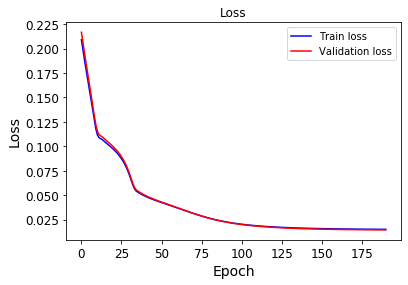

In [55]:
session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 


train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


In [0]:
y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
y_predicted_ar_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]

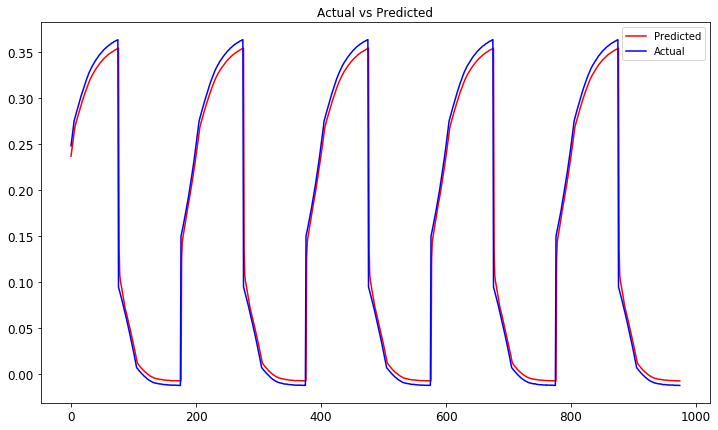

In [57]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()

## Cross-Validation

In [0]:
# Create a new instance of the alpha_RNN model
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
alpharnn_cv = alphaRNN(input_dimensions, hidden_size)

In [0]:
# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) #prediction

In [0]:
x_train_all = np.concatenate((x_train_reg, x_test_reg))
y_train_all = np.concatenate((y_train_reg, y_test_reg))

In [0]:
def cross_validate(session, split_size=2):

  results = []

  kf = KFold(n_splits=split_size)
  

  for train_idx, val_idx in kf.split(x_train_all, y_train_all):
    
    expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_all[train_idx]
    train_y = y_train_all[train_idx]

    val_x = x_train_all[val_idx]
    val_y = y_train_all[val_idx]

    run_train(session, train_x, train_y)
    val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    results.append(session.run(val_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y}))

  return results

In [0]:
with tf.Session() as session:

  
  result = cross_validate(session, 3)

  print('Cross-validation result: %s' % result)

  #print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn.input_layer: x_test_reg, expected_output_test: y_test_reg}))


Start training
9
Epoch #0 step=0 cost=0.274071
Epoch #0 step=1 cost=0.276030
Epoch #0 step=2 cost=0.228123
Epoch #0 step=3 cost=0.271589
Epoch #0 step=4 cost=0.245146
Epoch #0 step=5 cost=0.294200
Epoch #0 step=6 cost=0.248367
Epoch #0 step=7 cost=0.231228
Epoch #0 step=8 cost=0.250668
9
Epoch #1 step=0 cost=0.215120
Epoch #1 step=1 cost=0.190737
Epoch #1 step=2 cost=0.229877
Epoch #1 step=3 cost=0.180556
Epoch #1 step=4 cost=0.249311
Epoch #1 step=5 cost=0.203345
Epoch #1 step=6 cost=0.235156
Epoch #1 step=7 cost=0.255640
Epoch #1 step=8 cost=0.250929
9
Epoch #2 step=0 cost=0.217309
Epoch #2 step=1 cost=0.202617
Epoch #2 step=2 cost=0.245974
Epoch #2 step=3 cost=0.230031
Epoch #2 step=4 cost=0.256848
Epoch #2 step=5 cost=0.201583
Epoch #2 step=6 cost=0.180187
Epoch #2 step=7 cost=0.222978
Epoch #2 step=8 cost=0.191230
9
Epoch #3 step=0 cost=0.251219
Epoch #3 step=1 cost=0.224161
Epoch #3 step=2 cost=0.228348
Epoch #3 step=3 cost=0.193099
Epoch #3 step=4 cost=0.180634
Epoch #3 step=5 

KeyboardInterrupt: ignored

In [0]:
print(train_losses[0][1])

0.24908832024482616


## Diagnostics (visualize fitted values)

In [0]:
tf.get_collection('alpha_t')

[<tf.Tensor 'h_t_transposed/while/Sigmoid:0' shape=(?, 1) dtype=float64>]

In [0]:
# MFD: It would be good to visualize the amount of smoothing, but I get an error
# alpha_t=session.run(alpharnn.alpha_t, feed_dict={alpharnn.input_layer: x_test_reg})

In [0]:
#plt.plot(alpha_t[:,n_steps-1,1], 'red')
#pplt.plot(y_test_reg.flatten(),'blue')

# Comparsion with Keras GRU, RNN, LSTM

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.001)

MFD: batch size must match that used for alpha_RNN when comparing LSTM



### LSTM


In [71]:
# MFD: Also try GRU, SimpleRNN
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/1500
975/975 [==============================] - 2s 2ms/step - loss: 0.0256
Epoch 2/1500
975/975 [==============================] - 0s 92us/step - loss: 0.0164
Epoch 3/1500
975/975 [==============================] - 0s 90us/step - loss: 0.0109
Epoch 4/1500
100/975 [==>...........................] - ETA: 0s - loss: 0.0085

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


975/975 [==============================] - 0s 95us/step - loss: 0.0086
Epoch 5/1500
975/975 [==============================] - 0s 98us/step - loss: 0.0074
Epoch 6/1500
975/975 [==============================] - 0s 104us/step - loss: 0.0063
Epoch 7/1500
975/975 [==============================] - 0s 96us/step - loss: 0.0051
Epoch 8/1500
975/975 [==============================] - 0s 100us/step - loss: 0.0041
Epoch 9/1500
975/975 [==============================] - 0s 99us/step - loss: 0.0033
Epoch 10/1500
975/975 [==============================] - 0s 105us/step - loss: 0.0026
Epoch 11/1500
975/975 [==============================] - 0s 96us/step - loss: 0.0022
Epoch 12/1500
975/975 [==============================] - 0s 102us/step - loss: 0.0018
Epoch 13/1500
975/975 [==============================] - 0s 101us/step - loss: 0.0016
Epoch 14/1500
975/975 [==============================] - 0s 92us/step - loss: 0.0015
Epoch 15/1500
975/975 [==============================] - 0s 102us/step - loss: 

### RNN

In [72]:

rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/1500
975/975 [==============================] - 2s 2ms/step - loss: 0.1938
Epoch 2/1500
975/975 [==============================] - 0s 29us/step - loss: 0.1319
Epoch 3/1500
975/975 [==============================] - 0s 31us/step - loss: 0.0847
Epoch 4/1500
975/975 [==============================] - 0s 30us/step - loss: 0.0550
Epoch 5/1500
975/975 [==============================] - 0s 32us/step - loss: 0.0405
Epoch 6/1500
975/975 [==============================] - 0s 30us/step - loss: 0.0340
Epoch 7/1500
975/975 [==============================] - 0s 31us/step - loss: 0.0303
Epoch 8/1500
100/975 [==>...........................] - ETA: 0s - loss: 0.0284

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


975/975 [==============================] - 0s 36us/step - loss: 0.0272
Epoch 9/1500
975/975 [==============================] - 0s 33us/step - loss: 0.0244
Epoch 10/1500
975/975 [==============================] - 0s 39us/step - loss: 0.0218
Epoch 11/1500
975/975 [==============================] - 0s 36us/step - loss: 0.0195
Epoch 12/1500
975/975 [==============================] - 0s 34us/step - loss: 0.0172
Epoch 13/1500
975/975 [==============================] - 0s 30us/step - loss: 0.0150
Epoch 14/1500
975/975 [==============================] - 0s 29us/step - loss: 0.0129
Epoch 15/1500
975/975 [==============================] - 0s 30us/step - loss: 0.0109
Epoch 16/1500
975/975 [==============================] - 0s 31us/step - loss: 0.0092
Epoch 17/1500
975/975 [==============================] - 0s 34us/step - loss: 0.0077
Epoch 18/1500
975/975 [==============================] - 0s 30us/step - loss: 0.0066
Epoch 19/1500
975/975 [==============================] - 0s 30us/step - loss: 0.

### GRU

In [73]:
gru_model = Sequential()
gru_model.add(GRU(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

gru_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/1500
975/975 [==============================] - 2s 2ms/step - loss: 0.0147
Epoch 2/1500
975/975 [==============================] - 0s 76us/step - loss: 0.0087
Epoch 3/1500
975/975 [==============================] - 0s 79us/step - loss: 0.0064
Epoch 4/1500
100/975 [==>...........................] - ETA: 0s - loss: 0.0060

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


975/975 [==============================] - 0s 84us/step - loss: 0.0056
Epoch 5/1500
975/975 [==============================] - 0s 77us/step - loss: 0.0049
Epoch 6/1500
975/975 [==============================] - 0s 75us/step - loss: 0.0041
Epoch 7/1500
975/975 [==============================] - 0s 77us/step - loss: 0.0034
Epoch 8/1500
975/975 [==============================] - 0s 78us/step - loss: 0.0029
Epoch 9/1500
975/975 [==============================] - 0s 78us/step - loss: 0.0024
Epoch 10/1500
975/975 [==============================] - 0s 79us/step - loss: 0.0019
Epoch 11/1500
975/975 [==============================] - 0s 80us/step - loss: 0.0016
Epoch 12/1500
975/975 [==============================] - 0s 80us/step - loss: 0.0013
Epoch 13/1500
975/975 [==============================] - 0s 78us/step - loss: 0.0012
Epoch 14/1500
975/975 [==============================] - 0s 80us/step - loss: 0.0010
Epoch 15/1500
975/975 [==============================] - 0s 83us/step - loss: 9.4084

### Prediction

In [74]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

975/975 [==============================] - 0s 72us/step


In [75]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

975/975 [==============================] - 0s 38us/step


In [0]:
# compare with the trained plain GRU

In [76]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

975/975 [==============================] - 0s 50us/step


### Model Performance

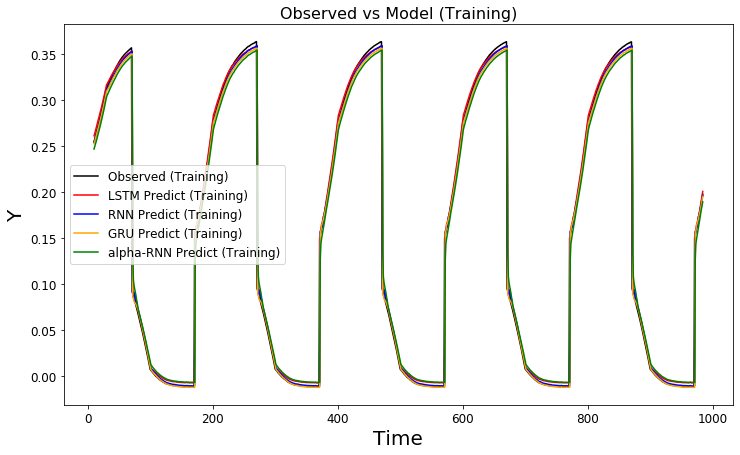

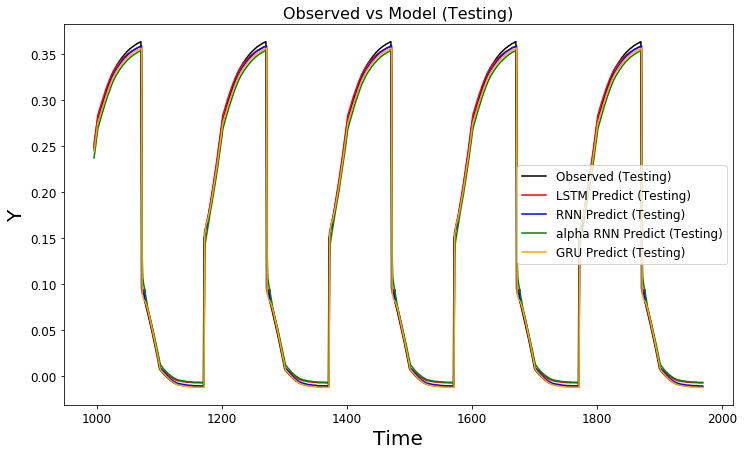

In [77]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], y_predicted_ar_train, color='green', label="alpha-RNN Predict (Training)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], lstm_pred_test[:, 0], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
testline_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar, color='green', label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="orange", label="GRU Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

# Error


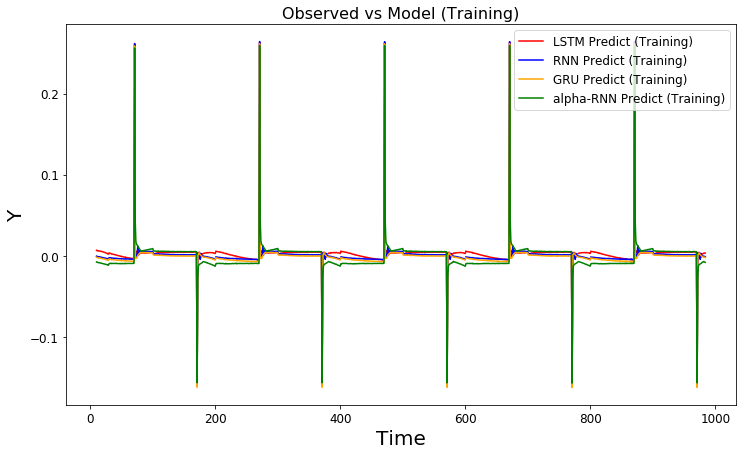

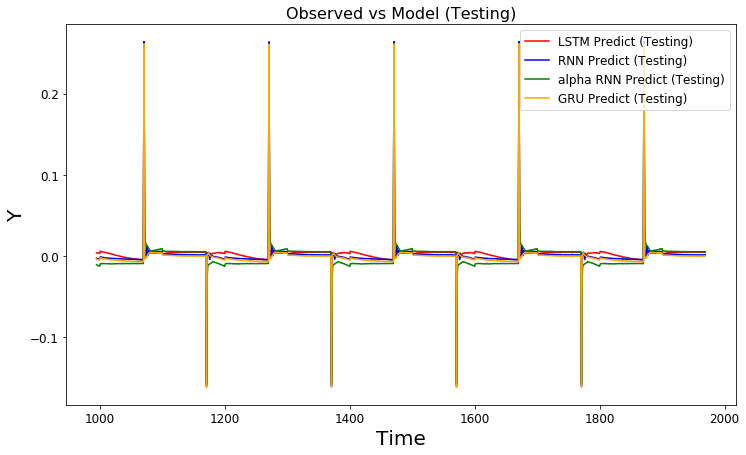

In [79]:
fig = plt.figure(figsize=(12,7))
#train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0]-df_train[use_feature][n_steps:], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0]-df_train[use_feature][n_steps:], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0]-df_train[use_feature][n_steps:], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], y_predicted_ar_train-df_train[use_feature][n_steps:], color='green', label="alpha-RNN Predict (Training)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(12,7))
#test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], lstm_pred_test[:, 0]-df_test[use_feature][n_steps:], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0]-df_test[use_feature][n_steps:], color="blue", label="RNN Predict (Testing)")
testline_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar-df_test[use_feature][n_steps:], color='green', label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0]-df_test[use_feature][n_steps:], color="orange", label="GRU Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

In [0]:
# calculate mean squared error of the plain LSTM
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], lstm_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

0.0007382025652623655
0.0005548327706811151


In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

0.0005604398243138546
0.00041628279420046236


In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], validation_losses[:, 0])
print(MSE_test)